In [247]:
### IMPORTS ###
import os, glob, re
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
import sklearn

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV

## Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier # KNN c
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
import lightgbm as lgb

## Evaluation
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [240]:
### GLOBAL VARIABLES ###
RAND_STATE = 0
N_FOLDS = 5

### FUNCTIONS ###
def saveResult(ypred_test, name):
    '''Saves predicted labels to csv file'''
    # Size of test set is 24421
    assert ypred_test.size == 24421
    results_dict = {
        "id": np.arange(1, ypred_test.size + 1),
        "prediction": ypred_test
    }
    results = pd.DataFrame(results_dict)
    path = "dump/submissions/" + name
    print("Saved submission file to:", path)
    results.to_csv(path, index=False)

def getPredictions(X):
    """ Converts probabilities in df to labels
    Args:
        X (dataframe): Columns correponds to probabilities of different models
    Returns:
        dataframe: Predicted labels (0 or 1)
    """
    predictions = np.zeros(X.shape)
    predictions[X > 0.5] = 1
    return pd.DataFrame(predictions, columns=list(X))

def runRandSearchCV(model, params_grid, params_search, filename):
    '''Run randomized cross-validation grid search and pickle best parameters'''
    
    list_lengths = [len(x) for x in params_grid.values()]
    n_comb = np.prod(list_lengths)
    print("No. of possible combinations:", n_comb)

    # Random search of parameters across n_iter different
    # combinations using all available cores
    model_gridsearch = RandomizedSearchCV(
        estimator=model,
        param_distributions=params_grid,
        n_jobs=-1,
        **params_search
    )
    model_gridsearch.fit(X_alltrain, y_alltrain)
    print(model_gridsearch.best_params_)
    
    params_wpath = os.path.join("dump/params/", filename)
    print("Saved parameters to:", params_wpath)
    with open(params_wpath, "wb") as f:
        pkl.dump(model_gridsearch.best_params_, f)

def runL1Model(model, X_alltrain, y_alltrain, algorithm="others"):
    if algorithm =="others":
        metrics = ["accuracy", "f1"]
        scores = cross_validate(model, X_alltrain, y_alltrain,
                                scoring=metrics, return_train_score=True)
        print(scores)
        print("Training set")
        print("Accuracy = {:.3f}% +/- {:.3f}".format(
            np.mean(scores["train_accuracy"]*100),
            np.std(scores["train_accuracy"]*100)))
        print("F1 = {:.3f}% +/- {:.3f}".format(
            np.mean(scores["train_f1"]*100),
            np.std(scores["train_f1"]*100)))
        print("Test set")
        print("Accuracy = {:.3f}% +/- {:.3f}".format(
            np.mean(scores["test_accuracy"]*100),
            np.std(scores["test_accuracy"]*100)))
        print("F1 = {:.3f}% +/- {:.3f}".format(
            np.mean(scores["test_f1"]*100),
            np.std(scores["test_f1"]*100)))
        return None
    
    else:
        X_train, X_vld, y_train, y_vld = train_test_split(
            allp_alltrain, y_alltrain,
            test_size=0.2, random_state=RAND_STATE)
        model.fit(X_train, y_train, eval_set=[(X_vld, y_vld)])
    
        # HOLDOUT SET
        p_train = model.predict_proba(X_train)[:,1]
        ypred_train = (p_train > 0.5).astype(int)
        p_vld = model.predict_proba(X_vld)[:,1]
        ypred_vld = (p_vld > 0.5).astype(int)

        print("Train set:")
        #     print(classification_report(y_train, ypred_train))
        print(confusion_matrix(y_train, ypred_train))
        print("Accuracy = {:.5f}, F1 = {:.5f}".format(
            accuracy_score(y_train, ypred_train)*100,
            f1_score(y_train, ypred_train)*100))

        print("Validation set:")
        #     print(classification_report(y_vld, ypred_vld))
        print(confusion_matrix(y_vld, ypred_vld))
        print("Accuracy = {:.3f}, F1 = {:.3f}\n".format(
            accuracy_score(y_vld, ypred_vld)*100,
            f1_score(y_vld, ypred_vld)*100))
        return None
    
def saveL1Test(model, X_alltrain, y_alltrain, X_test, filename):
    model.fit(X_alltrain, y_alltrain)
    ypred_test = model.predict(X_test)
    saveResult(ypred_test, filename)

In [72]:
## Import y_alltrain
TRAIN_RPATH = "dump/data/nopp_alltrain.pkl"
with open(TRAIN_RPATH, "rb") as f:
    _, y_alltrain = pkl.load(f)

In [193]:
## Import L1 features
L1_WPATH1 = "dump/data/L1_wxpp1_pca.pkl"
with open(L1_WPATH1, "rb") as f:
    pca_alltrain, pca_test = pkl.load(f)
print(pca_alltrain.shape)
print(pca_test.shape)

(24421, 4)
(24421, 4)


### Import model probabilities

In [124]:
RDIR = "dump/proba/stack1/*"
list_files = glob.glob(RDIR)
list_files.sort()

model_names = [re.search(".*/(.*).pkl", rpath).group(1)
               for rpath in list_files]
allp_alltrain = pd.DataFrame(columns=model_names)
allp_test = pd.DataFrame(columns=model_names)

# Concatenate all probabilities to form dataframe
for rpath, name in zip(list_files, model_names):
    with open(rpath, "rb") as f:
        p_alltrain, p_test = pkl.load(f)
    allp_alltrain[name] = p_alltrain
    allp_test[name] = p_test
    
print(allp_alltrain.shape)
print(allp_test.shape)

(24421, 9)
(24421, 9)
(19536, 9)
(19536,)
(4885, 9)
(4885,)


In [202]:
## Concatenate model outputs and L1 features
X_alltrain = np.hstack([allp_alltrain, pca_alltrain])
print(X_alltrain.shape)
X_test = np.hstack([allp_test, pca_test])
print(X_test.shape)

(24421, 13)
(24421, 13)


In [225]:
## Split into training and validation set
X_train, X_vld, y_train, y_vld = train_test_split(allp_alltrain, y_alltrain,
                                                  test_size=0.2, random_state=RAND_STATE)
print(X_train.shape)
print(y_train.shape)
print(X_vld.shape)
print(y_vld.shape)

(19536, 9)
(19536,)
(4885, 9)
(4885,)


### Evaluation: Individual models

In [87]:
allypred_alltrain = getPredictions(allp_alltrain)

print("Training set:")
for colname, ypred_alltrain in allypred_alltrain.iteritems():
    print(colname)
    print("Accuracy = {:.5f}, F1 = {:.5f}".format(
        accuracy_score(y_alltrain, ypred_alltrain),
        f1_score(y_alltrain, ypred_alltrain)))

   nopp_et2  nopp_lgbm1  nopp_lgbm2  nopp_rf1
1  0.409499    0.167117    0.413303  0.235081
2  0.517222    0.168331    0.393304  0.191319
3  0.875894    0.714366    0.875786  0.753849
4  0.812275    0.967121    0.993581  0.886488
   nopp_et2  nopp_lgbm1  nopp_lgbm2  nopp_rf1
1       0.0         0.0         0.0       0.0
2       1.0         0.0         0.0       0.0
3       1.0         1.0         1.0       1.0
4       1.0         1.0         1.0       1.0
Training set:
nopp_et1
Accuracy = 0.84816, F1 = 0.64476
nopp_et2
Accuracy = 0.80509, F1 = 0.67500
nopp_lgbm1
Accuracy = 0.87326, F1 = 0.71587
nopp_lgbm2
Accuracy = 0.83981, F1 = 0.72021
nopp_rf1
Accuracy = 0.86282, F1 = 0.68258
nopp_rf2
Accuracy = 0.83481, F1 = 0.70700
nopp_xgb1
Accuracy = 0.87326, F1 = 0.71477
nopp_xgb2
Accuracy = 0.84358, F1 = 0.72367
wxpp_knn1
Accuracy = 0.79653, F1 = 0.33949


### Evaluation: Correlation between model predictions

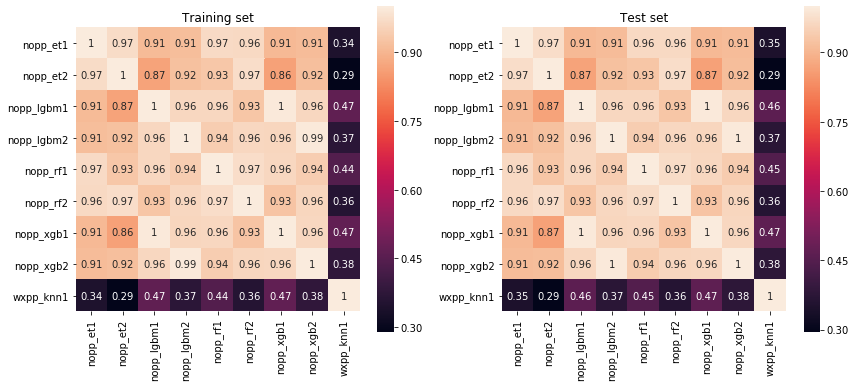

In [192]:
corr_alltrain = allp_alltrain.corr(method='pearson')
corr_test = allp_test.corr(method='pearson')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
sns.heatmap(corr_alltrain, square=True, annot=True, ax=ax1)
sns.heatmap(corr_test, square=True, annot=True, ax=ax2)
ax1.set_title("Training set")
ax2.set_title("Test set")
plt.show()

### Stacking: Hard voting

In [95]:
allypred_alltrain = getPredictions(allp_alltrain)
print(allp_alltrain.iloc[1:5,1:5])
print(allypred_alltrain.iloc[1:5,1:5])

# Average the predicted labels
voteL1_p_alltrain = allypred_alltrain.mean(axis=1)
voteL1_ypred_alltrain = (voteL1_p_alltrain > 0.5).astype(int)

print("Train set:")
print(classification_report(y_alltrain, voteL1_ypred_alltrain))
print(confusion_matrix(y_alltrain, voteL1_ypred_alltrain))
print("Accuracy = {:.5f}, F1 = {:.5f}".format(
    accuracy_score(y_alltrain, voteL1_ypred_alltrain),
    f1_score(y_alltrain, voteL1_ypred_alltrain)))

   nopp_et2  nopp_lgbm1  nopp_lgbm2  nopp_rf1
1  0.409499    0.167117    0.413303  0.235081
2  0.517222    0.168331    0.393304  0.191319
3  0.875894    0.714366    0.875786  0.753849
4  0.812275    0.967121    0.993581  0.886488
   nopp_et2  nopp_lgbm1  nopp_lgbm2  nopp_rf1
1       0.0         0.0         0.0       0.0
2       1.0         0.0         0.0       0.0
3       1.0         1.0         1.0       1.0
4       1.0         1.0         1.0       1.0
Train set:
              precision    recall  f1-score   support

           0       0.91      0.92      0.92     18560
           1       0.75      0.70      0.72      5861

    accuracy                           0.87     24421
   macro avg       0.83      0.81      0.82     24421
weighted avg       0.87      0.87      0.87     24421

[[17164  1396]
 [ 1746  4115]]
Accuracy = 0.87134, F1 = 0.72371


In [98]:
# Test set predictions
allypred_test = getPredictions(allp_test)
print(allp_test.iloc[1:5,1:5])
print(allypred_test.iloc[1:5,1:5], "\n")

voteL1_p_test = allypred_test.mean(axis=1)
voteL1_ypred_test = (voteL1_p_test > 0.5).astype(int)
saveResult(voteL1_ypred_test, "stack1_vote.csv")

   nopp_et2  nopp_lgbm1  nopp_lgbm2  nopp_rf1
1  0.244020    0.010171    0.014171  0.088398
2  0.180621    0.013157    0.039981  0.029455
3  0.333171    0.176918    0.445093  0.208681
4  0.017519    0.002298    0.007532  0.004912
   nopp_et2  nopp_lgbm1  nopp_lgbm2  nopp_rf1
1       0.0         0.0         0.0       0.0
2       0.0         0.0         0.0       0.0
3       0.0         0.0         0.0       0.0
4       0.0         0.0         0.0       0.0 

Saved submission file to: dump/submissions/stack1_vote.csv


### Stacking: Soft averaging

In [99]:
avgL1_p_alltrain = allp_alltrain.mean(axis=1)
avgL1_ypred_alltrain = (avgL1_p_alltrain > 0.5).astype(int)

print("Train set:")
print(classification_report(y_alltrain, avgL1_ypred_alltrain))
print(confusion_matrix(y_alltrain, avgL1_ypred_alltrain))
print("Accuracy = {:.5f}, F1 = {:.5f}".format(
    accuracy_score(y_alltrain, avgL1_ypred_alltrain),
    f1_score(y_alltrain, avgL1_ypred_alltrain)))

Train set:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91     18560
           1       0.73      0.72      0.73      5861

    accuracy                           0.87     24421
   macro avg       0.82      0.82      0.82     24421
weighted avg       0.87      0.87      0.87     24421

[[16967  1593]
 [ 1614  4247]]
Accuracy = 0.86868, F1 = 0.72592


In [100]:
# Test set predictions
avgL1_p_test = allp_test.mean(axis=1)
avgL1_ypred_test = (avgL1_p_test > 0.5).astype(int)
saveResult(avgL1_ypred_test, "stack1_avg.csv")

Saved submission file to: dump/submissions/stack1_avg.csv


### Stacking: Logistic Regression

In [230]:
## MODEL 1
logreg = LogisticRegression(class_weight=None)

runL1Model(logreg, X_train, X_vld, y_train, y_vld)
# saveL1Test(logreg, allp_alltrain, y_alltrain,
#            allp_test, "stack1_logreg1.csv")

metrics = ["accuracy", "f1"]
scores = cross_validate(logreg, allp_alltrain, y_alltrain,
                        scoring=metrics, return_train_score=True)
print(scores)
print("Training set")
print("Accuracy = {:.3f}% +/- {:.3f}".format(
    np.mean(scores["train_accuracy"]*100),
    np.std(scores["train_accuracy"]*100)))
print("F1 = {:.3f}% +/- {:.3f}".format(
    np.mean(scores["train_f1"]*100),
    np.std(scores["train_f1"]*100)))
print("Test set")
print("Accuracy = {:.3f}% +/- {:.3f}".format(
    np.mean(scores["test_accuracy"]*100),
    np.std(scores["test_accuracy"]*100)))
print("F1 = {:.3f}% +/- {:.3f}".format(
    np.mean(scores["test_f1"]*100),
    np.std(scores["test_f1"]*100)))

Train set:
[[13771  1077]
 [ 1417  3271]]
Accuracy = 87.23382, F1 = 72.39929
Validation set:
[[3450  262]
 [ 362  811]]
Accuracy = 87.226, F1 = 72.217

{'fit_time': array([0.16043305, 0.13748407, 0.14231181, 0.14241338, 0.14790249]), 'score_time': array([0.00577879, 0.00561142, 0.00560284, 0.00562859, 0.00550389]), 'test_accuracy': array([0.87103378, 0.88124488, 0.87366912, 0.87264537, 0.86588862]), 'train_accuracy': array([0.87300369, 0.87034857, 0.87214004, 0.87321493, 0.87480166]), 'test_f1': array([0.71875   , 0.74760661, 0.72638581, 0.72207328, 0.70667264]), 'train_f1': array([0.72473094, 0.71858682, 0.72330527, 0.72505273, 0.72852386])}
Training set
Accuracy = 87.270% +/- 0.146
F1 = 72.404% +/- 0.322
Test set
Accuracy = 87.290% +/- 0.496
F1 = 72.430% +/- 1.337


In [138]:
## MODEL 2 (Class imbalance)
logreg = LogisticRegression(class_weight="balanced")
runL1Model(logreg, X_train, X_vld, y_train, y_vld)
saveL1Test(logreg, allp_alltrain, y_alltrain,
           allp_test, "stack1_logreg2.csv")

Train set:
[[12438  2410]
 [  654  4034]]
Accuracy = 84.31613, F1 = 72.47575
Validation set:
[[3101  611]
 [ 181  992]]
Accuracy = 83.787, F1 = 71.470

Saved submission file to: dump/submissions/stack1_logreg2.csv


### Stacked: MLP

In [219]:
params_mlp = {
    hidden_layer_sizes=(12,15,18,18,18,12,12),
    max_iter=1000,
    alpha=1e-4,
    solver='adam',
    verbose=10,
    random_state=RAND_STATE,
    learning_rate_init=0.01
}
mlp = MLPClassifier()

runL1Model(mlp, X_train, X_vld, y_train, y_vld)
saveL1Test(logreg, allp_alltrain, y_alltrain,
           allp_test, "stack1_mlp1.csv")

Iteration 1, loss = 0.32909329
Iteration 2, loss = 0.28642028
Iteration 3, loss = 0.28861466
Iteration 4, loss = 0.28332092
Iteration 5, loss = 0.28291886
Iteration 6, loss = 0.28540101
Iteration 7, loss = 0.28789549
Iteration 8, loss = 0.28284544
Iteration 9, loss = 0.28153289
Iteration 10, loss = 0.28168048
Iteration 11, loss = 0.28116840
Iteration 12, loss = 0.28057353
Iteration 13, loss = 0.28048307
Iteration 14, loss = 0.28012669
Iteration 15, loss = 0.28100985
Iteration 16, loss = 0.27955764
Iteration 17, loss = 0.28038467
Iteration 18, loss = 0.28184940
Iteration 19, loss = 0.27958051
Iteration 20, loss = 0.28037441
Iteration 21, loss = 0.28097147
Iteration 22, loss = 0.27938338
Iteration 23, loss = 0.27897441
Iteration 24, loss = 0.28068379
Iteration 25, loss = 0.28095513
Iteration 26, loss = 0.27942572
Iteration 27, loss = 0.27851219
Iteration 28, loss = 0.27823568
Iteration 29, loss = 0.27984246
Iteration 30, loss = 0.28034530
Iteration 31, loss = 0.27862137
Iteration 32, los

### Stacked: Random Forest

In [210]:
params_model = {
    'n_estimators': 3000,
    'min_samples_split': 5,
    'min_samples_leaf': 5,
    'max_features': 'auto',
    'max_depth': 10,
    'bootstrap': True
}
rf = RandomForestClassifier(**params_model, random_state=RAND_STATE)
runL1Model(rf, X_train, X_vld, y_train, y_vld)
# saveL1Test(rf, allp_alltrain, y_alltrain,
#            allp_test, "stack1_rf1.csv")

Train set:
[[14105   743]
 [ 1341  3347]]
Accuracy = 89.33251, F1 = 76.25883
Validation set:
[[3499  213]
 [ 392  781]]
Accuracy = 87.615, F1 = 72.081



### Stacked: ExtraTrees

In [223]:
params_et = {
    'n_estimators': 5000,
    'criterion': 'entropy', # entropy
    'min_samples_split': 5,
    'min_samples_leaf': 5,
    'max_features': 'auto',
    'max_depth': 20,
    'bootstrap': True,
    'random_state': RAND_STATE,
    'class_weight': 'balanced_subsample'
}
et = ExtraTreesClassifier(**params_et)
runL1Model(et, X_train, X_vld, y_train, y_vld)
# saveL1Test(et, allp_alltrain, y_alltrain,
#            allp_test, "stack1_et1.csv")

Train set:
[[12666  2182]
 [  487  4201]]
Accuracy = 86.33804, F1 = 75.89197
Validation set:
[[3120  592]
 [ 183  990]]
Accuracy = 84.135, F1 = 71.869



### Stacked: XGBoost

In [204]:
params_xgb = {
    'booster': 'gbtree',
    'max_depth': 4,
    'learning_rate': 0.01,
    'objective': 'binary:logistic',
    'reg_alpha': 0.1,
    'reg_lambda': 100,
    'n_estimators': 15000
}
xgb = XGBClassifier(**params_xgb)
runL1Model(xgb, X_train, X_vld, y_train, y_vld, early_stopping=True)
# saveL1Test(xgb, allp_alltrain, y_alltrain,
#            allp_test, "stack1_xgb1.csv")

[0]	validation_0-error:0.12794
[1]	validation_0-error:0.12794
[2]	validation_0-error:0.12733
[3]	validation_0-error:0.12712
[4]	validation_0-error:0.12794
[5]	validation_0-error:0.12794
[6]	validation_0-error:0.12794
[7]	validation_0-error:0.12794
[8]	validation_0-error:0.12794
[9]	validation_0-error:0.12774
[10]	validation_0-error:0.12794
[11]	validation_0-error:0.12794
[12]	validation_0-error:0.12794
[13]	validation_0-error:0.12712
[14]	validation_0-error:0.12774
[15]	validation_0-error:0.12671
[16]	validation_0-error:0.12671
[17]	validation_0-error:0.12651
[18]	validation_0-error:0.12651
[19]	validation_0-error:0.12671
[20]	validation_0-error:0.12671
[21]	validation_0-error:0.12671
[22]	validation_0-error:0.12651
[23]	validation_0-error:0.12671
[24]	validation_0-error:0.12651
[25]	validation_0-error:0.12671
[26]	validation_0-error:0.12671
[27]	validation_0-error:0.12651
[28]	validation_0-error:0.12651
[29]	validation_0-error:0.12651
[30]	validation_0-error:0.12651
[31]	validation_0-

[252]	validation_0-error:0.12631
[253]	validation_0-error:0.12631
[254]	validation_0-error:0.12631
[255]	validation_0-error:0.12631
[256]	validation_0-error:0.12631
[257]	validation_0-error:0.12631
[258]	validation_0-error:0.12631
[259]	validation_0-error:0.12631
[260]	validation_0-error:0.12651
[261]	validation_0-error:0.12651
[262]	validation_0-error:0.12651
[263]	validation_0-error:0.12651
[264]	validation_0-error:0.12631
[265]	validation_0-error:0.12631
[266]	validation_0-error:0.12631
[267]	validation_0-error:0.12631
[268]	validation_0-error:0.12610
[269]	validation_0-error:0.12610
[270]	validation_0-error:0.12610
[271]	validation_0-error:0.12610
[272]	validation_0-error:0.12610
[273]	validation_0-error:0.12610
[274]	validation_0-error:0.12610
[275]	validation_0-error:0.12610
[276]	validation_0-error:0.12610
[277]	validation_0-error:0.12610
[278]	validation_0-error:0.12610
[279]	validation_0-error:0.12610
[280]	validation_0-error:0.12610
[281]	validation_0-error:0.12610
[282]	vali

[501]	validation_0-error:0.12712
[502]	validation_0-error:0.12712
[503]	validation_0-error:0.12712
[504]	validation_0-error:0.12712
[505]	validation_0-error:0.12712
[506]	validation_0-error:0.12712
[507]	validation_0-error:0.12712
[508]	validation_0-error:0.12712
[509]	validation_0-error:0.12712
[510]	validation_0-error:0.12712
[511]	validation_0-error:0.12712
[512]	validation_0-error:0.12712
[513]	validation_0-error:0.12712
[514]	validation_0-error:0.12712
[515]	validation_0-error:0.12712
[516]	validation_0-error:0.12712
[517]	validation_0-error:0.12712
[518]	validation_0-error:0.12712
[519]	validation_0-error:0.12712
[520]	validation_0-error:0.12712
[521]	validation_0-error:0.12712
[522]	validation_0-error:0.12712
[523]	validation_0-error:0.12712
[524]	validation_0-error:0.12712
[525]	validation_0-error:0.12712
[526]	validation_0-error:0.12712
[527]	validation_0-error:0.12712
[528]	validation_0-error:0.12712
[529]	validation_0-error:0.12712
[530]	validation_0-error:0.12712
[531]	vali

[750]	validation_0-error:0.12651
[751]	validation_0-error:0.12651
[752]	validation_0-error:0.12651
[753]	validation_0-error:0.12651
[754]	validation_0-error:0.12651
[755]	validation_0-error:0.12651
[756]	validation_0-error:0.12651
[757]	validation_0-error:0.12651
[758]	validation_0-error:0.12651
[759]	validation_0-error:0.12651
[760]	validation_0-error:0.12651
[761]	validation_0-error:0.12651
[762]	validation_0-error:0.12651
[763]	validation_0-error:0.12651
[764]	validation_0-error:0.12651
[765]	validation_0-error:0.12651
[766]	validation_0-error:0.12651
[767]	validation_0-error:0.12651
[768]	validation_0-error:0.12651
[769]	validation_0-error:0.12651
[770]	validation_0-error:0.12651
[771]	validation_0-error:0.12651
[772]	validation_0-error:0.12651
[773]	validation_0-error:0.12651
[774]	validation_0-error:0.12651
[775]	validation_0-error:0.12651
[776]	validation_0-error:0.12651
[777]	validation_0-error:0.12671
[778]	validation_0-error:0.12671
[779]	validation_0-error:0.12671
[780]	vali

[999]	validation_0-error:0.12651
[1000]	validation_0-error:0.12651
[1001]	validation_0-error:0.12651
[1002]	validation_0-error:0.12651
[1003]	validation_0-error:0.12651
[1004]	validation_0-error:0.12631
[1005]	validation_0-error:0.12631
[1006]	validation_0-error:0.12631
[1007]	validation_0-error:0.12631
[1008]	validation_0-error:0.12631
[1009]	validation_0-error:0.12651
[1010]	validation_0-error:0.12651
[1011]	validation_0-error:0.12651
[1012]	validation_0-error:0.12651
[1013]	validation_0-error:0.12651
[1014]	validation_0-error:0.12651
[1015]	validation_0-error:0.12651
[1016]	validation_0-error:0.12651
[1017]	validation_0-error:0.12651
[1018]	validation_0-error:0.12651
[1019]	validation_0-error:0.12651
[1020]	validation_0-error:0.12651
[1021]	validation_0-error:0.12651
[1022]	validation_0-error:0.12651
[1023]	validation_0-error:0.12651
[1024]	validation_0-error:0.12651
[1025]	validation_0-error:0.12651
[1026]	validation_0-error:0.12651
[1027]	validation_0-error:0.12651
[1028]	validati

[1240]	validation_0-error:0.12528
[1241]	validation_0-error:0.12528
[1242]	validation_0-error:0.12528
[1243]	validation_0-error:0.12528
[1244]	validation_0-error:0.12528
[1245]	validation_0-error:0.12528
[1246]	validation_0-error:0.12528
[1247]	validation_0-error:0.12528
[1248]	validation_0-error:0.12528
[1249]	validation_0-error:0.12528
[1250]	validation_0-error:0.12528
[1251]	validation_0-error:0.12528
[1252]	validation_0-error:0.12528
[1253]	validation_0-error:0.12528
[1254]	validation_0-error:0.12528
[1255]	validation_0-error:0.12528
[1256]	validation_0-error:0.12528
[1257]	validation_0-error:0.12528
[1258]	validation_0-error:0.12528
[1259]	validation_0-error:0.12528
[1260]	validation_0-error:0.12528
[1261]	validation_0-error:0.12528
[1262]	validation_0-error:0.12528
[1263]	validation_0-error:0.12528
[1264]	validation_0-error:0.12528
[1265]	validation_0-error:0.12528
[1266]	validation_0-error:0.12528
[1267]	validation_0-error:0.12528
[1268]	validation_0-error:0.12528
[1269]	validat

[1481]	validation_0-error:0.12549
[1482]	validation_0-error:0.12549
[1483]	validation_0-error:0.12549
[1484]	validation_0-error:0.12549
[1485]	validation_0-error:0.12549
[1486]	validation_0-error:0.12549
[1487]	validation_0-error:0.12549
[1488]	validation_0-error:0.12549
[1489]	validation_0-error:0.12549
[1490]	validation_0-error:0.12549
[1491]	validation_0-error:0.12549
[1492]	validation_0-error:0.12549
[1493]	validation_0-error:0.12549
[1494]	validation_0-error:0.12549
[1495]	validation_0-error:0.12549
[1496]	validation_0-error:0.12549
[1497]	validation_0-error:0.12549
[1498]	validation_0-error:0.12549
[1499]	validation_0-error:0.12549
[1500]	validation_0-error:0.12549
[1501]	validation_0-error:0.12549
[1502]	validation_0-error:0.12549
[1503]	validation_0-error:0.12549
[1504]	validation_0-error:0.12549
[1505]	validation_0-error:0.12549
[1506]	validation_0-error:0.12549
[1507]	validation_0-error:0.12549
[1508]	validation_0-error:0.12549
[1509]	validation_0-error:0.12549
[1510]	validat

[1722]	validation_0-error:0.12569
[1723]	validation_0-error:0.12569
[1724]	validation_0-error:0.12569
[1725]	validation_0-error:0.12569
[1726]	validation_0-error:0.12569
[1727]	validation_0-error:0.12569
[1728]	validation_0-error:0.12569
[1729]	validation_0-error:0.12569
[1730]	validation_0-error:0.12569
[1731]	validation_0-error:0.12569
[1732]	validation_0-error:0.12569
[1733]	validation_0-error:0.12569
[1734]	validation_0-error:0.12569
[1735]	validation_0-error:0.12569
[1736]	validation_0-error:0.12569
[1737]	validation_0-error:0.12569
[1738]	validation_0-error:0.12569
[1739]	validation_0-error:0.12569
[1740]	validation_0-error:0.12569
[1741]	validation_0-error:0.12569
[1742]	validation_0-error:0.12569
[1743]	validation_0-error:0.12569
[1744]	validation_0-error:0.12569
[1745]	validation_0-error:0.12569
[1746]	validation_0-error:0.12569
[1747]	validation_0-error:0.12569
[1748]	validation_0-error:0.12569
[1749]	validation_0-error:0.12549
[1750]	validation_0-error:0.12549
[1751]	validat

[1963]	validation_0-error:0.12508
[1964]	validation_0-error:0.12508
[1965]	validation_0-error:0.12508
[1966]	validation_0-error:0.12508
[1967]	validation_0-error:0.12528
[1968]	validation_0-error:0.12528
[1969]	validation_0-error:0.12508
[1970]	validation_0-error:0.12508
[1971]	validation_0-error:0.12528
[1972]	validation_0-error:0.12508
[1973]	validation_0-error:0.12528
[1974]	validation_0-error:0.12528
[1975]	validation_0-error:0.12528
[1976]	validation_0-error:0.12528
[1977]	validation_0-error:0.12508
[1978]	validation_0-error:0.12508
[1979]	validation_0-error:0.12487
[1980]	validation_0-error:0.12487
[1981]	validation_0-error:0.12487
[1982]	validation_0-error:0.12508
[1983]	validation_0-error:0.12508
[1984]	validation_0-error:0.12508
[1985]	validation_0-error:0.12508
[1986]	validation_0-error:0.12508
[1987]	validation_0-error:0.12508
[1988]	validation_0-error:0.12508
[1989]	validation_0-error:0.12528
[1990]	validation_0-error:0.12508
[1991]	validation_0-error:0.12528
[1992]	validat

[2204]	validation_0-error:0.12549
[2205]	validation_0-error:0.12549
[2206]	validation_0-error:0.12549
[2207]	validation_0-error:0.12549
[2208]	validation_0-error:0.12549
[2209]	validation_0-error:0.12549
[2210]	validation_0-error:0.12549
[2211]	validation_0-error:0.12549
[2212]	validation_0-error:0.12569
[2213]	validation_0-error:0.12549
[2214]	validation_0-error:0.12569
[2215]	validation_0-error:0.12549
[2216]	validation_0-error:0.12549
[2217]	validation_0-error:0.12569
[2218]	validation_0-error:0.12569
[2219]	validation_0-error:0.12569
[2220]	validation_0-error:0.12569
[2221]	validation_0-error:0.12569
[2222]	validation_0-error:0.12569
[2223]	validation_0-error:0.12569
[2224]	validation_0-error:0.12569
[2225]	validation_0-error:0.12569
[2226]	validation_0-error:0.12569
[2227]	validation_0-error:0.12569
[2228]	validation_0-error:0.12590
[2229]	validation_0-error:0.12569
[2230]	validation_0-error:0.12590
[2231]	validation_0-error:0.12590
[2232]	validation_0-error:0.12610
[2233]	validat

[2445]	validation_0-error:0.12590
[2446]	validation_0-error:0.12590
[2447]	validation_0-error:0.12590
[2448]	validation_0-error:0.12610
[2449]	validation_0-error:0.12610
[2450]	validation_0-error:0.12610
[2451]	validation_0-error:0.12631
[2452]	validation_0-error:0.12631
[2453]	validation_0-error:0.12631
[2454]	validation_0-error:0.12631
[2455]	validation_0-error:0.12631
[2456]	validation_0-error:0.12631
[2457]	validation_0-error:0.12631
[2458]	validation_0-error:0.12631
[2459]	validation_0-error:0.12631
[2460]	validation_0-error:0.12631
[2461]	validation_0-error:0.12631
[2462]	validation_0-error:0.12631
[2463]	validation_0-error:0.12631
[2464]	validation_0-error:0.12631
[2465]	validation_0-error:0.12631
[2466]	validation_0-error:0.12631
[2467]	validation_0-error:0.12631
[2468]	validation_0-error:0.12631
[2469]	validation_0-error:0.12631
[2470]	validation_0-error:0.12631
[2471]	validation_0-error:0.12631
[2472]	validation_0-error:0.12631
[2473]	validation_0-error:0.12631
[2474]	validat

[2686]	validation_0-error:0.12549
[2687]	validation_0-error:0.12549
[2688]	validation_0-error:0.12549
[2689]	validation_0-error:0.12549
[2690]	validation_0-error:0.12569
[2691]	validation_0-error:0.12590
[2692]	validation_0-error:0.12590
[2693]	validation_0-error:0.12590
[2694]	validation_0-error:0.12590
[2695]	validation_0-error:0.12590
[2696]	validation_0-error:0.12590
[2697]	validation_0-error:0.12590
[2698]	validation_0-error:0.12590
[2699]	validation_0-error:0.12590
[2700]	validation_0-error:0.12590
[2701]	validation_0-error:0.12590
[2702]	validation_0-error:0.12590
[2703]	validation_0-error:0.12590
[2704]	validation_0-error:0.12610
[2705]	validation_0-error:0.12610
[2706]	validation_0-error:0.12610
[2707]	validation_0-error:0.12610
[2708]	validation_0-error:0.12610
[2709]	validation_0-error:0.12610
[2710]	validation_0-error:0.12590
[2711]	validation_0-error:0.12610
[2712]	validation_0-error:0.12610
[2713]	validation_0-error:0.12610
[2714]	validation_0-error:0.12610
[2715]	validat

[2927]	validation_0-error:0.12651
[2928]	validation_0-error:0.12671
[2929]	validation_0-error:0.12671
[2930]	validation_0-error:0.12671
[2931]	validation_0-error:0.12671
[2932]	validation_0-error:0.12671
[2933]	validation_0-error:0.12671
[2934]	validation_0-error:0.12692
[2935]	validation_0-error:0.12692
[2936]	validation_0-error:0.12692
[2937]	validation_0-error:0.12692
[2938]	validation_0-error:0.12692
[2939]	validation_0-error:0.12692
[2940]	validation_0-error:0.12692
[2941]	validation_0-error:0.12692
[2942]	validation_0-error:0.12692
[2943]	validation_0-error:0.12692
[2944]	validation_0-error:0.12692
[2945]	validation_0-error:0.12692
[2946]	validation_0-error:0.12671
[2947]	validation_0-error:0.12671
[2948]	validation_0-error:0.12671
[2949]	validation_0-error:0.12671
[2950]	validation_0-error:0.12671
[2951]	validation_0-error:0.12671
[2952]	validation_0-error:0.12671
[2953]	validation_0-error:0.12671
[2954]	validation_0-error:0.12671
[2955]	validation_0-error:0.12671
[2956]	validat

[3168]	validation_0-error:0.12712
[3169]	validation_0-error:0.12712
[3170]	validation_0-error:0.12712
[3171]	validation_0-error:0.12712
[3172]	validation_0-error:0.12712
[3173]	validation_0-error:0.12712
[3174]	validation_0-error:0.12692
[3175]	validation_0-error:0.12692
[3176]	validation_0-error:0.12692
[3177]	validation_0-error:0.12692
[3178]	validation_0-error:0.12692
[3179]	validation_0-error:0.12692
[3180]	validation_0-error:0.12692
[3181]	validation_0-error:0.12692
[3182]	validation_0-error:0.12692
[3183]	validation_0-error:0.12692
[3184]	validation_0-error:0.12692
[3185]	validation_0-error:0.12692
[3186]	validation_0-error:0.12692
[3187]	validation_0-error:0.12692
[3188]	validation_0-error:0.12692
[3189]	validation_0-error:0.12712
[3190]	validation_0-error:0.12712
[3191]	validation_0-error:0.12712
[3192]	validation_0-error:0.12712
[3193]	validation_0-error:0.12712
[3194]	validation_0-error:0.12733
[3195]	validation_0-error:0.12733
[3196]	validation_0-error:0.12733
[3197]	validat

[3409]	validation_0-error:0.12692
[3410]	validation_0-error:0.12671
[3411]	validation_0-error:0.12671
[3412]	validation_0-error:0.12671
[3413]	validation_0-error:0.12671
[3414]	validation_0-error:0.12671
[3415]	validation_0-error:0.12671
[3416]	validation_0-error:0.12671
[3417]	validation_0-error:0.12671
[3418]	validation_0-error:0.12671
[3419]	validation_0-error:0.12671
[3420]	validation_0-error:0.12671
[3421]	validation_0-error:0.12692
[3422]	validation_0-error:0.12692
[3423]	validation_0-error:0.12692
[3424]	validation_0-error:0.12692
[3425]	validation_0-error:0.12692
[3426]	validation_0-error:0.12692
[3427]	validation_0-error:0.12692
[3428]	validation_0-error:0.12692
[3429]	validation_0-error:0.12692
[3430]	validation_0-error:0.12692
[3431]	validation_0-error:0.12692
[3432]	validation_0-error:0.12692
[3433]	validation_0-error:0.12692
[3434]	validation_0-error:0.12692
[3435]	validation_0-error:0.12692
[3436]	validation_0-error:0.12671
[3437]	validation_0-error:0.12671
[3438]	validat

[3650]	validation_0-error:0.12651
[3651]	validation_0-error:0.12651
[3652]	validation_0-error:0.12651
[3653]	validation_0-error:0.12651
[3654]	validation_0-error:0.12651
[3655]	validation_0-error:0.12651
[3656]	validation_0-error:0.12651
[3657]	validation_0-error:0.12651
[3658]	validation_0-error:0.12651
[3659]	validation_0-error:0.12651
[3660]	validation_0-error:0.12651
[3661]	validation_0-error:0.12651
[3662]	validation_0-error:0.12651
[3663]	validation_0-error:0.12651
[3664]	validation_0-error:0.12671
[3665]	validation_0-error:0.12671
[3666]	validation_0-error:0.12671
[3667]	validation_0-error:0.12671
[3668]	validation_0-error:0.12671
[3669]	validation_0-error:0.12692
[3670]	validation_0-error:0.12692
[3671]	validation_0-error:0.12692
[3672]	validation_0-error:0.12692
[3673]	validation_0-error:0.12692
[3674]	validation_0-error:0.12692
[3675]	validation_0-error:0.12692
[3676]	validation_0-error:0.12692
[3677]	validation_0-error:0.12692
[3678]	validation_0-error:0.12692
[3679]	validat

[3891]	validation_0-error:0.12590
[3892]	validation_0-error:0.12590
[3893]	validation_0-error:0.12590
[3894]	validation_0-error:0.12590
[3895]	validation_0-error:0.12590
[3896]	validation_0-error:0.12590
[3897]	validation_0-error:0.12590
[3898]	validation_0-error:0.12590
[3899]	validation_0-error:0.12590
[3900]	validation_0-error:0.12590
[3901]	validation_0-error:0.12590
[3902]	validation_0-error:0.12590
[3903]	validation_0-error:0.12590
[3904]	validation_0-error:0.12590
[3905]	validation_0-error:0.12590
[3906]	validation_0-error:0.12590
[3907]	validation_0-error:0.12590
[3908]	validation_0-error:0.12590
[3909]	validation_0-error:0.12590
[3910]	validation_0-error:0.12590
[3911]	validation_0-error:0.12590
[3912]	validation_0-error:0.12590
[3913]	validation_0-error:0.12590
[3914]	validation_0-error:0.12590
[3915]	validation_0-error:0.12590
[3916]	validation_0-error:0.12590
[3917]	validation_0-error:0.12590
[3918]	validation_0-error:0.12590
[3919]	validation_0-error:0.12590
[3920]	validat

[4132]	validation_0-error:0.12651
[4133]	validation_0-error:0.12651
[4134]	validation_0-error:0.12651
[4135]	validation_0-error:0.12651
[4136]	validation_0-error:0.12651
[4137]	validation_0-error:0.12651
[4138]	validation_0-error:0.12671
[4139]	validation_0-error:0.12651
[4140]	validation_0-error:0.12651
[4141]	validation_0-error:0.12651
[4142]	validation_0-error:0.12651
[4143]	validation_0-error:0.12671
[4144]	validation_0-error:0.12671
[4145]	validation_0-error:0.12671
[4146]	validation_0-error:0.12671
[4147]	validation_0-error:0.12651
[4148]	validation_0-error:0.12651
[4149]	validation_0-error:0.12651
[4150]	validation_0-error:0.12671
[4151]	validation_0-error:0.12671
[4152]	validation_0-error:0.12671
[4153]	validation_0-error:0.12651
[4154]	validation_0-error:0.12671
[4155]	validation_0-error:0.12671
[4156]	validation_0-error:0.12692
[4157]	validation_0-error:0.12692
[4158]	validation_0-error:0.12671
[4159]	validation_0-error:0.12671
[4160]	validation_0-error:0.12692
[4161]	validat

[4373]	validation_0-error:0.12671
[4374]	validation_0-error:0.12692
[4375]	validation_0-error:0.12692
[4376]	validation_0-error:0.12692
[4377]	validation_0-error:0.12692
[4378]	validation_0-error:0.12692
[4379]	validation_0-error:0.12692
[4380]	validation_0-error:0.12692
[4381]	validation_0-error:0.12671
[4382]	validation_0-error:0.12671
[4383]	validation_0-error:0.12671
[4384]	validation_0-error:0.12671
[4385]	validation_0-error:0.12671
[4386]	validation_0-error:0.12671
[4387]	validation_0-error:0.12671
[4388]	validation_0-error:0.12671
[4389]	validation_0-error:0.12671
[4390]	validation_0-error:0.12671
[4391]	validation_0-error:0.12671
[4392]	validation_0-error:0.12692
[4393]	validation_0-error:0.12692
[4394]	validation_0-error:0.12692
[4395]	validation_0-error:0.12692
[4396]	validation_0-error:0.12692
[4397]	validation_0-error:0.12692
[4398]	validation_0-error:0.12692
[4399]	validation_0-error:0.12671
[4400]	validation_0-error:0.12671
[4401]	validation_0-error:0.12671
[4402]	validat

[4614]	validation_0-error:0.12712
[4615]	validation_0-error:0.12712
[4616]	validation_0-error:0.12712
[4617]	validation_0-error:0.12692
[4618]	validation_0-error:0.12692
[4619]	validation_0-error:0.12712
[4620]	validation_0-error:0.12712
[4621]	validation_0-error:0.12733
[4622]	validation_0-error:0.12733
[4623]	validation_0-error:0.12733
[4624]	validation_0-error:0.12733
[4625]	validation_0-error:0.12733
[4626]	validation_0-error:0.12753
[4627]	validation_0-error:0.12753
[4628]	validation_0-error:0.12753
[4629]	validation_0-error:0.12774
[4630]	validation_0-error:0.12774
[4631]	validation_0-error:0.12794
[4632]	validation_0-error:0.12774
[4633]	validation_0-error:0.12774
[4634]	validation_0-error:0.12774
[4635]	validation_0-error:0.12774
[4636]	validation_0-error:0.12774
[4637]	validation_0-error:0.12774
[4638]	validation_0-error:0.12774
[4639]	validation_0-error:0.12774
[4640]	validation_0-error:0.12774
[4641]	validation_0-error:0.12774
[4642]	validation_0-error:0.12774
[4643]	validat

[4855]	validation_0-error:0.12712
[4856]	validation_0-error:0.12712
[4857]	validation_0-error:0.12712
[4858]	validation_0-error:0.12712
[4859]	validation_0-error:0.12712
[4860]	validation_0-error:0.12712
[4861]	validation_0-error:0.12712
[4862]	validation_0-error:0.12712
[4863]	validation_0-error:0.12712
[4864]	validation_0-error:0.12712
[4865]	validation_0-error:0.12712
[4866]	validation_0-error:0.12712
[4867]	validation_0-error:0.12712
[4868]	validation_0-error:0.12712
[4869]	validation_0-error:0.12712
[4870]	validation_0-error:0.12712
[4871]	validation_0-error:0.12712
[4872]	validation_0-error:0.12712
[4873]	validation_0-error:0.12712
[4874]	validation_0-error:0.12712
[4875]	validation_0-error:0.12712
[4876]	validation_0-error:0.12712
[4877]	validation_0-error:0.12712
[4878]	validation_0-error:0.12712
[4879]	validation_0-error:0.12712
[4880]	validation_0-error:0.12712
[4881]	validation_0-error:0.12712
[4882]	validation_0-error:0.12712
[4883]	validation_0-error:0.12733
[4884]	validat

[5096]	validation_0-error:0.12692
[5097]	validation_0-error:0.12692
[5098]	validation_0-error:0.12692
[5099]	validation_0-error:0.12692
[5100]	validation_0-error:0.12692
[5101]	validation_0-error:0.12712
[5102]	validation_0-error:0.12712
[5103]	validation_0-error:0.12712
[5104]	validation_0-error:0.12712
[5105]	validation_0-error:0.12712
[5106]	validation_0-error:0.12712
[5107]	validation_0-error:0.12712
[5108]	validation_0-error:0.12692
[5109]	validation_0-error:0.12692
[5110]	validation_0-error:0.12692
[5111]	validation_0-error:0.12692
[5112]	validation_0-error:0.12692
[5113]	validation_0-error:0.12692
[5114]	validation_0-error:0.12692
[5115]	validation_0-error:0.12692
[5116]	validation_0-error:0.12692
[5117]	validation_0-error:0.12692
[5118]	validation_0-error:0.12692
[5119]	validation_0-error:0.12692
[5120]	validation_0-error:0.12692
[5121]	validation_0-error:0.12692
[5122]	validation_0-error:0.12712
[5123]	validation_0-error:0.12712
[5124]	validation_0-error:0.12712
[5125]	validat

[5337]	validation_0-error:0.12671
[5338]	validation_0-error:0.12671
[5339]	validation_0-error:0.12671
[5340]	validation_0-error:0.12671
[5341]	validation_0-error:0.12671
[5342]	validation_0-error:0.12671
[5343]	validation_0-error:0.12671
[5344]	validation_0-error:0.12671
[5345]	validation_0-error:0.12671
[5346]	validation_0-error:0.12671
[5347]	validation_0-error:0.12671
[5348]	validation_0-error:0.12671
[5349]	validation_0-error:0.12671
[5350]	validation_0-error:0.12671
[5351]	validation_0-error:0.12671
[5352]	validation_0-error:0.12671
[5353]	validation_0-error:0.12671
[5354]	validation_0-error:0.12671
[5355]	validation_0-error:0.12692
[5356]	validation_0-error:0.12692
[5357]	validation_0-error:0.12692
[5358]	validation_0-error:0.12692
[5359]	validation_0-error:0.12692
[5360]	validation_0-error:0.12692
[5361]	validation_0-error:0.12692
[5362]	validation_0-error:0.12692
[5363]	validation_0-error:0.12692
[5364]	validation_0-error:0.12692
[5365]	validation_0-error:0.12692
[5366]	validat

[5578]	validation_0-error:0.12733
[5579]	validation_0-error:0.12733
[5580]	validation_0-error:0.12733
[5581]	validation_0-error:0.12733
[5582]	validation_0-error:0.12733
[5583]	validation_0-error:0.12733
[5584]	validation_0-error:0.12733
[5585]	validation_0-error:0.12733
[5586]	validation_0-error:0.12733
[5587]	validation_0-error:0.12733
[5588]	validation_0-error:0.12733
[5589]	validation_0-error:0.12733
[5590]	validation_0-error:0.12733
[5591]	validation_0-error:0.12733
[5592]	validation_0-error:0.12733
[5593]	validation_0-error:0.12733
[5594]	validation_0-error:0.12733
[5595]	validation_0-error:0.12733
[5596]	validation_0-error:0.12733
[5597]	validation_0-error:0.12733
[5598]	validation_0-error:0.12733
[5599]	validation_0-error:0.12733
[5600]	validation_0-error:0.12733
[5601]	validation_0-error:0.12733
[5602]	validation_0-error:0.12733
[5603]	validation_0-error:0.12733
[5604]	validation_0-error:0.12733
[5605]	validation_0-error:0.12733
[5606]	validation_0-error:0.12733
[5607]	validat

[5819]	validation_0-error:0.12712
[5820]	validation_0-error:0.12712
[5821]	validation_0-error:0.12712
[5822]	validation_0-error:0.12712
[5823]	validation_0-error:0.12712
[5824]	validation_0-error:0.12712
[5825]	validation_0-error:0.12712
[5826]	validation_0-error:0.12712
[5827]	validation_0-error:0.12712
[5828]	validation_0-error:0.12712
[5829]	validation_0-error:0.12712
[5830]	validation_0-error:0.12712
[5831]	validation_0-error:0.12712
[5832]	validation_0-error:0.12712
[5833]	validation_0-error:0.12712
[5834]	validation_0-error:0.12712
[5835]	validation_0-error:0.12712
[5836]	validation_0-error:0.12712
[5837]	validation_0-error:0.12712
[5838]	validation_0-error:0.12712
[5839]	validation_0-error:0.12712
[5840]	validation_0-error:0.12712
[5841]	validation_0-error:0.12712
[5842]	validation_0-error:0.12712
[5843]	validation_0-error:0.12712
[5844]	validation_0-error:0.12712
[5845]	validation_0-error:0.12712
[5846]	validation_0-error:0.12712
[5847]	validation_0-error:0.12712
[5848]	validat

[6060]	validation_0-error:0.12733
[6061]	validation_0-error:0.12733
[6062]	validation_0-error:0.12733
[6063]	validation_0-error:0.12733
[6064]	validation_0-error:0.12733
[6065]	validation_0-error:0.12733
[6066]	validation_0-error:0.12733
[6067]	validation_0-error:0.12733
[6068]	validation_0-error:0.12733
[6069]	validation_0-error:0.12733
[6070]	validation_0-error:0.12733
[6071]	validation_0-error:0.12733
[6072]	validation_0-error:0.12733
[6073]	validation_0-error:0.12733
[6074]	validation_0-error:0.12733
[6075]	validation_0-error:0.12733
[6076]	validation_0-error:0.12733
[6077]	validation_0-error:0.12733
[6078]	validation_0-error:0.12733
[6079]	validation_0-error:0.12733
[6080]	validation_0-error:0.12733
[6081]	validation_0-error:0.12733
[6082]	validation_0-error:0.12733
[6083]	validation_0-error:0.12733
[6084]	validation_0-error:0.12733
[6085]	validation_0-error:0.12733
[6086]	validation_0-error:0.12733
[6087]	validation_0-error:0.12733
[6088]	validation_0-error:0.12733
[6089]	validat

[6301]	validation_0-error:0.12733
[6302]	validation_0-error:0.12733
[6303]	validation_0-error:0.12712
[6304]	validation_0-error:0.12712
[6305]	validation_0-error:0.12733
[6306]	validation_0-error:0.12733
[6307]	validation_0-error:0.12733
[6308]	validation_0-error:0.12753
[6309]	validation_0-error:0.12753
[6310]	validation_0-error:0.12753
[6311]	validation_0-error:0.12753
[6312]	validation_0-error:0.12753
[6313]	validation_0-error:0.12753
[6314]	validation_0-error:0.12753
[6315]	validation_0-error:0.12733
[6316]	validation_0-error:0.12733
[6317]	validation_0-error:0.12733
[6318]	validation_0-error:0.12733
[6319]	validation_0-error:0.12733
[6320]	validation_0-error:0.12733
[6321]	validation_0-error:0.12733
[6322]	validation_0-error:0.12733
[6323]	validation_0-error:0.12733
[6324]	validation_0-error:0.12733
[6325]	validation_0-error:0.12733
[6326]	validation_0-error:0.12733
[6327]	validation_0-error:0.12733
[6328]	validation_0-error:0.12733
[6329]	validation_0-error:0.12712
[6330]	validat

[6542]	validation_0-error:0.12733
[6543]	validation_0-error:0.12733
[6544]	validation_0-error:0.12733
[6545]	validation_0-error:0.12733
[6546]	validation_0-error:0.12733
[6547]	validation_0-error:0.12733
[6548]	validation_0-error:0.12733
[6549]	validation_0-error:0.12733
[6550]	validation_0-error:0.12733
[6551]	validation_0-error:0.12733
[6552]	validation_0-error:0.12733
[6553]	validation_0-error:0.12733
[6554]	validation_0-error:0.12733
[6555]	validation_0-error:0.12733
[6556]	validation_0-error:0.12733
[6557]	validation_0-error:0.12733
[6558]	validation_0-error:0.12733
[6559]	validation_0-error:0.12733
[6560]	validation_0-error:0.12733
[6561]	validation_0-error:0.12733
[6562]	validation_0-error:0.12733
[6563]	validation_0-error:0.12733
[6564]	validation_0-error:0.12733
[6565]	validation_0-error:0.12733
[6566]	validation_0-error:0.12733
[6567]	validation_0-error:0.12733
[6568]	validation_0-error:0.12733
[6569]	validation_0-error:0.12733
[6570]	validation_0-error:0.12733
[6571]	validat

[6783]	validation_0-error:0.12712
[6784]	validation_0-error:0.12712
[6785]	validation_0-error:0.12712
[6786]	validation_0-error:0.12712
[6787]	validation_0-error:0.12712
[6788]	validation_0-error:0.12712
[6789]	validation_0-error:0.12712
[6790]	validation_0-error:0.12712
[6791]	validation_0-error:0.12692
[6792]	validation_0-error:0.12692
[6793]	validation_0-error:0.12692
[6794]	validation_0-error:0.12692
[6795]	validation_0-error:0.12692
[6796]	validation_0-error:0.12692
[6797]	validation_0-error:0.12692
[6798]	validation_0-error:0.12692
[6799]	validation_0-error:0.12692
[6800]	validation_0-error:0.12692
[6801]	validation_0-error:0.12692
[6802]	validation_0-error:0.12692
[6803]	validation_0-error:0.12712
[6804]	validation_0-error:0.12712
[6805]	validation_0-error:0.12712
[6806]	validation_0-error:0.12692
[6807]	validation_0-error:0.12733
[6808]	validation_0-error:0.12733
[6809]	validation_0-error:0.12733
[6810]	validation_0-error:0.12733
[6811]	validation_0-error:0.12733
[6812]	validat

[7024]	validation_0-error:0.12712
[7025]	validation_0-error:0.12712
[7026]	validation_0-error:0.12712
[7027]	validation_0-error:0.12712
[7028]	validation_0-error:0.12712
[7029]	validation_0-error:0.12712
[7030]	validation_0-error:0.12712
[7031]	validation_0-error:0.12712
[7032]	validation_0-error:0.12712
[7033]	validation_0-error:0.12712
[7034]	validation_0-error:0.12712
[7035]	validation_0-error:0.12712
[7036]	validation_0-error:0.12712
[7037]	validation_0-error:0.12692
[7038]	validation_0-error:0.12692
[7039]	validation_0-error:0.12692
[7040]	validation_0-error:0.12692
[7041]	validation_0-error:0.12692
[7042]	validation_0-error:0.12692
[7043]	validation_0-error:0.12692
[7044]	validation_0-error:0.12692
[7045]	validation_0-error:0.12692
[7046]	validation_0-error:0.12692
[7047]	validation_0-error:0.12692
[7048]	validation_0-error:0.12692
[7049]	validation_0-error:0.12692
[7050]	validation_0-error:0.12692
[7051]	validation_0-error:0.12692
[7052]	validation_0-error:0.12692
[7053]	validat

[7265]	validation_0-error:0.12774
[7266]	validation_0-error:0.12774
[7267]	validation_0-error:0.12774
[7268]	validation_0-error:0.12774
[7269]	validation_0-error:0.12774
[7270]	validation_0-error:0.12774
[7271]	validation_0-error:0.12774
[7272]	validation_0-error:0.12774
[7273]	validation_0-error:0.12774
[7274]	validation_0-error:0.12774
[7275]	validation_0-error:0.12774
[7276]	validation_0-error:0.12774
[7277]	validation_0-error:0.12774
[7278]	validation_0-error:0.12774
[7279]	validation_0-error:0.12774
[7280]	validation_0-error:0.12774
[7281]	validation_0-error:0.12794
[7282]	validation_0-error:0.12794
[7283]	validation_0-error:0.12794
[7284]	validation_0-error:0.12794
[7285]	validation_0-error:0.12794
[7286]	validation_0-error:0.12794
[7287]	validation_0-error:0.12794
[7288]	validation_0-error:0.12794
[7289]	validation_0-error:0.12794
[7290]	validation_0-error:0.12794
[7291]	validation_0-error:0.12794
[7292]	validation_0-error:0.12794
[7293]	validation_0-error:0.12794
[7294]	validat

[7506]	validation_0-error:0.12897
[7507]	validation_0-error:0.12897
[7508]	validation_0-error:0.12897
[7509]	validation_0-error:0.12897
[7510]	validation_0-error:0.12897
[7511]	validation_0-error:0.12897
[7512]	validation_0-error:0.12897
[7513]	validation_0-error:0.12876
[7514]	validation_0-error:0.12856
[7515]	validation_0-error:0.12876
[7516]	validation_0-error:0.12876
[7517]	validation_0-error:0.12876
[7518]	validation_0-error:0.12876
[7519]	validation_0-error:0.12876
[7520]	validation_0-error:0.12876
[7521]	validation_0-error:0.12876
[7522]	validation_0-error:0.12876
[7523]	validation_0-error:0.12897
[7524]	validation_0-error:0.12897
[7525]	validation_0-error:0.12897
[7526]	validation_0-error:0.12897
[7527]	validation_0-error:0.12897
[7528]	validation_0-error:0.12897
[7529]	validation_0-error:0.12897
[7530]	validation_0-error:0.12897
[7531]	validation_0-error:0.12897
[7532]	validation_0-error:0.12897
[7533]	validation_0-error:0.12897
[7534]	validation_0-error:0.12897
[7535]	validat

[7747]	validation_0-error:0.12774
[7748]	validation_0-error:0.12774
[7749]	validation_0-error:0.12774
[7750]	validation_0-error:0.12774
[7751]	validation_0-error:0.12774
[7752]	validation_0-error:0.12774
[7753]	validation_0-error:0.12774
[7754]	validation_0-error:0.12774
[7755]	validation_0-error:0.12774
[7756]	validation_0-error:0.12774
[7757]	validation_0-error:0.12774
[7758]	validation_0-error:0.12753
[7759]	validation_0-error:0.12753
[7760]	validation_0-error:0.12774
[7761]	validation_0-error:0.12774
[7762]	validation_0-error:0.12753
[7763]	validation_0-error:0.12753
[7764]	validation_0-error:0.12753
[7765]	validation_0-error:0.12753
[7766]	validation_0-error:0.12753
[7767]	validation_0-error:0.12753
[7768]	validation_0-error:0.12753
[7769]	validation_0-error:0.12753
[7770]	validation_0-error:0.12753
[7771]	validation_0-error:0.12753
[7772]	validation_0-error:0.12753
[7773]	validation_0-error:0.12753
[7774]	validation_0-error:0.12753
[7775]	validation_0-error:0.12753
[7776]	validat

[7988]	validation_0-error:0.12794
[7989]	validation_0-error:0.12794
[7990]	validation_0-error:0.12794
[7991]	validation_0-error:0.12794
[7992]	validation_0-error:0.12794
[7993]	validation_0-error:0.12794
[7994]	validation_0-error:0.12794
[7995]	validation_0-error:0.12794
[7996]	validation_0-error:0.12794
[7997]	validation_0-error:0.12794
[7998]	validation_0-error:0.12794
[7999]	validation_0-error:0.12794
[8000]	validation_0-error:0.12794
[8001]	validation_0-error:0.12794
[8002]	validation_0-error:0.12794
[8003]	validation_0-error:0.12794
[8004]	validation_0-error:0.12794
[8005]	validation_0-error:0.12794
[8006]	validation_0-error:0.12794
[8007]	validation_0-error:0.12794
[8008]	validation_0-error:0.12794
[8009]	validation_0-error:0.12794
[8010]	validation_0-error:0.12794
[8011]	validation_0-error:0.12794
[8012]	validation_0-error:0.12794
[8013]	validation_0-error:0.12794
[8014]	validation_0-error:0.12794
[8015]	validation_0-error:0.12794
[8016]	validation_0-error:0.12794
[8017]	validat

[8229]	validation_0-error:0.12794
[8230]	validation_0-error:0.12794
[8231]	validation_0-error:0.12794
[8232]	validation_0-error:0.12794
[8233]	validation_0-error:0.12794
[8234]	validation_0-error:0.12794
[8235]	validation_0-error:0.12794
[8236]	validation_0-error:0.12794
[8237]	validation_0-error:0.12794
[8238]	validation_0-error:0.12794
[8239]	validation_0-error:0.12794
[8240]	validation_0-error:0.12794
[8241]	validation_0-error:0.12794
[8242]	validation_0-error:0.12815
[8243]	validation_0-error:0.12815
[8244]	validation_0-error:0.12794
[8245]	validation_0-error:0.12794
[8246]	validation_0-error:0.12794
[8247]	validation_0-error:0.12794
[8248]	validation_0-error:0.12794
[8249]	validation_0-error:0.12794
[8250]	validation_0-error:0.12794
[8251]	validation_0-error:0.12794
[8252]	validation_0-error:0.12794
[8253]	validation_0-error:0.12794
[8254]	validation_0-error:0.12794
[8255]	validation_0-error:0.12815
[8256]	validation_0-error:0.12815
[8257]	validation_0-error:0.12815
[8258]	validat

[8470]	validation_0-error:0.12856
[8471]	validation_0-error:0.12856
[8472]	validation_0-error:0.12856
[8473]	validation_0-error:0.12856
[8474]	validation_0-error:0.12856
[8475]	validation_0-error:0.12856
[8476]	validation_0-error:0.12856
[8477]	validation_0-error:0.12856
[8478]	validation_0-error:0.12856
[8479]	validation_0-error:0.12856
[8480]	validation_0-error:0.12856
[8481]	validation_0-error:0.12856
[8482]	validation_0-error:0.12856
[8483]	validation_0-error:0.12856
[8484]	validation_0-error:0.12856
[8485]	validation_0-error:0.12856
[8486]	validation_0-error:0.12856
[8487]	validation_0-error:0.12856
[8488]	validation_0-error:0.12856
[8489]	validation_0-error:0.12856
[8490]	validation_0-error:0.12856
[8491]	validation_0-error:0.12856
[8492]	validation_0-error:0.12856
[8493]	validation_0-error:0.12856
[8494]	validation_0-error:0.12856
[8495]	validation_0-error:0.12856
[8496]	validation_0-error:0.12856
[8497]	validation_0-error:0.12856
[8498]	validation_0-error:0.12856
[8499]	validat

[8711]	validation_0-error:0.12856
[8712]	validation_0-error:0.12856
[8713]	validation_0-error:0.12856
[8714]	validation_0-error:0.12856
[8715]	validation_0-error:0.12856
[8716]	validation_0-error:0.12856
[8717]	validation_0-error:0.12856
[8718]	validation_0-error:0.12856
[8719]	validation_0-error:0.12856
[8720]	validation_0-error:0.12856
[8721]	validation_0-error:0.12856
[8722]	validation_0-error:0.12856
[8723]	validation_0-error:0.12856
[8724]	validation_0-error:0.12856
[8725]	validation_0-error:0.12856
[8726]	validation_0-error:0.12856
[8727]	validation_0-error:0.12856
[8728]	validation_0-error:0.12856
[8729]	validation_0-error:0.12856
[8730]	validation_0-error:0.12856
[8731]	validation_0-error:0.12856
[8732]	validation_0-error:0.12856
[8733]	validation_0-error:0.12856
[8734]	validation_0-error:0.12856
[8735]	validation_0-error:0.12856
[8736]	validation_0-error:0.12876
[8737]	validation_0-error:0.12876
[8738]	validation_0-error:0.12876
[8739]	validation_0-error:0.12876
[8740]	validat

[8952]	validation_0-error:0.12835
[8953]	validation_0-error:0.12835
[8954]	validation_0-error:0.12835
[8955]	validation_0-error:0.12835
[8956]	validation_0-error:0.12835
[8957]	validation_0-error:0.12835
[8958]	validation_0-error:0.12835
[8959]	validation_0-error:0.12835
[8960]	validation_0-error:0.12835
[8961]	validation_0-error:0.12835
[8962]	validation_0-error:0.12815
[8963]	validation_0-error:0.12835
[8964]	validation_0-error:0.12815
[8965]	validation_0-error:0.12815
[8966]	validation_0-error:0.12815
[8967]	validation_0-error:0.12815
[8968]	validation_0-error:0.12794
[8969]	validation_0-error:0.12794
[8970]	validation_0-error:0.12794
[8971]	validation_0-error:0.12835
[8972]	validation_0-error:0.12815
[8973]	validation_0-error:0.12815
[8974]	validation_0-error:0.12815
[8975]	validation_0-error:0.12815
[8976]	validation_0-error:0.12815
[8977]	validation_0-error:0.12815
[8978]	validation_0-error:0.12815
[8979]	validation_0-error:0.12815
[8980]	validation_0-error:0.12815
[8981]	validat

[9193]	validation_0-error:0.12774
[9194]	validation_0-error:0.12774
[9195]	validation_0-error:0.12774
[9196]	validation_0-error:0.12774
[9197]	validation_0-error:0.12774
[9198]	validation_0-error:0.12774
[9199]	validation_0-error:0.12774
[9200]	validation_0-error:0.12774
[9201]	validation_0-error:0.12774
[9202]	validation_0-error:0.12774
[9203]	validation_0-error:0.12774
[9204]	validation_0-error:0.12774
[9205]	validation_0-error:0.12774
[9206]	validation_0-error:0.12774
[9207]	validation_0-error:0.12774
[9208]	validation_0-error:0.12774
[9209]	validation_0-error:0.12774
[9210]	validation_0-error:0.12774
[9211]	validation_0-error:0.12774
[9212]	validation_0-error:0.12774
[9213]	validation_0-error:0.12774
[9214]	validation_0-error:0.12774
[9215]	validation_0-error:0.12774
[9216]	validation_0-error:0.12774
[9217]	validation_0-error:0.12774
[9218]	validation_0-error:0.12774
[9219]	validation_0-error:0.12774
[9220]	validation_0-error:0.12774
[9221]	validation_0-error:0.12774
[9222]	validat

[9434]	validation_0-error:0.12753
[9435]	validation_0-error:0.12753
[9436]	validation_0-error:0.12753
[9437]	validation_0-error:0.12753
[9438]	validation_0-error:0.12753
[9439]	validation_0-error:0.12753
[9440]	validation_0-error:0.12753
[9441]	validation_0-error:0.12753
[9442]	validation_0-error:0.12753
[9443]	validation_0-error:0.12753
[9444]	validation_0-error:0.12753
[9445]	validation_0-error:0.12753
[9446]	validation_0-error:0.12753
[9447]	validation_0-error:0.12774
[9448]	validation_0-error:0.12774
[9449]	validation_0-error:0.12774
[9450]	validation_0-error:0.12774
[9451]	validation_0-error:0.12774
[9452]	validation_0-error:0.12774
[9453]	validation_0-error:0.12774
[9454]	validation_0-error:0.12774
[9455]	validation_0-error:0.12774
[9456]	validation_0-error:0.12774
[9457]	validation_0-error:0.12774
[9458]	validation_0-error:0.12774
[9459]	validation_0-error:0.12774
[9460]	validation_0-error:0.12774
[9461]	validation_0-error:0.12774
[9462]	validation_0-error:0.12774
[9463]	validat

[9675]	validation_0-error:0.12753
[9676]	validation_0-error:0.12753
[9677]	validation_0-error:0.12753
[9678]	validation_0-error:0.12753
[9679]	validation_0-error:0.12753
[9680]	validation_0-error:0.12753
[9681]	validation_0-error:0.12753
[9682]	validation_0-error:0.12753
[9683]	validation_0-error:0.12753
[9684]	validation_0-error:0.12753
[9685]	validation_0-error:0.12753
[9686]	validation_0-error:0.12753
[9687]	validation_0-error:0.12753
[9688]	validation_0-error:0.12753
[9689]	validation_0-error:0.12753
[9690]	validation_0-error:0.12753
[9691]	validation_0-error:0.12753
[9692]	validation_0-error:0.12753
[9693]	validation_0-error:0.12753
[9694]	validation_0-error:0.12753
[9695]	validation_0-error:0.12753
[9696]	validation_0-error:0.12753
[9697]	validation_0-error:0.12753
[9698]	validation_0-error:0.12753
[9699]	validation_0-error:0.12753
[9700]	validation_0-error:0.12753
[9701]	validation_0-error:0.12753
[9702]	validation_0-error:0.12753
[9703]	validation_0-error:0.12753
[9704]	validat

[9916]	validation_0-error:0.12774
[9917]	validation_0-error:0.12774
[9918]	validation_0-error:0.12753
[9919]	validation_0-error:0.12753
[9920]	validation_0-error:0.12753
[9921]	validation_0-error:0.12753
[9922]	validation_0-error:0.12753
[9923]	validation_0-error:0.12753
[9924]	validation_0-error:0.12753
[9925]	validation_0-error:0.12753
[9926]	validation_0-error:0.12753
[9927]	validation_0-error:0.12753
[9928]	validation_0-error:0.12753
[9929]	validation_0-error:0.12753
[9930]	validation_0-error:0.12753
[9931]	validation_0-error:0.12753
[9932]	validation_0-error:0.12753
[9933]	validation_0-error:0.12753
[9934]	validation_0-error:0.12753
[9935]	validation_0-error:0.12753
[9936]	validation_0-error:0.12753
[9937]	validation_0-error:0.12753
[9938]	validation_0-error:0.12753
[9939]	validation_0-error:0.12753
[9940]	validation_0-error:0.12753
[9941]	validation_0-error:0.12753
[9942]	validation_0-error:0.12753
[9943]	validation_0-error:0.12753
[9944]	validation_0-error:0.12753
[9945]	validat

[10153]	validation_0-error:0.12815
[10154]	validation_0-error:0.12815
[10155]	validation_0-error:0.12815
[10156]	validation_0-error:0.12815
[10157]	validation_0-error:0.12815
[10158]	validation_0-error:0.12815
[10159]	validation_0-error:0.12815
[10160]	validation_0-error:0.12815
[10161]	validation_0-error:0.12815
[10162]	validation_0-error:0.12815
[10163]	validation_0-error:0.12815
[10164]	validation_0-error:0.12815
[10165]	validation_0-error:0.12815
[10166]	validation_0-error:0.12815
[10167]	validation_0-error:0.12815
[10168]	validation_0-error:0.12815
[10169]	validation_0-error:0.12815
[10170]	validation_0-error:0.12815
[10171]	validation_0-error:0.12815
[10172]	validation_0-error:0.12815
[10173]	validation_0-error:0.12815
[10174]	validation_0-error:0.12815
[10175]	validation_0-error:0.12815
[10176]	validation_0-error:0.12815
[10177]	validation_0-error:0.12815
[10178]	validation_0-error:0.12815
[10179]	validation_0-error:0.12815
[10180]	validation_0-error:0.12815
[10181]	validation_0

[10388]	validation_0-error:0.12794
[10389]	validation_0-error:0.12794
[10390]	validation_0-error:0.12794
[10391]	validation_0-error:0.12794
[10392]	validation_0-error:0.12794
[10393]	validation_0-error:0.12794
[10394]	validation_0-error:0.12794
[10395]	validation_0-error:0.12794
[10396]	validation_0-error:0.12794
[10397]	validation_0-error:0.12794
[10398]	validation_0-error:0.12794
[10399]	validation_0-error:0.12794
[10400]	validation_0-error:0.12794
[10401]	validation_0-error:0.12794
[10402]	validation_0-error:0.12794
[10403]	validation_0-error:0.12794
[10404]	validation_0-error:0.12794
[10405]	validation_0-error:0.12794
[10406]	validation_0-error:0.12794
[10407]	validation_0-error:0.12794
[10408]	validation_0-error:0.12794
[10409]	validation_0-error:0.12794
[10410]	validation_0-error:0.12794
[10411]	validation_0-error:0.12794
[10412]	validation_0-error:0.12794
[10413]	validation_0-error:0.12794
[10414]	validation_0-error:0.12794
[10415]	validation_0-error:0.12794
[10416]	validation_0

[10623]	validation_0-error:0.12794
[10624]	validation_0-error:0.12794
[10625]	validation_0-error:0.12794
[10626]	validation_0-error:0.12794
[10627]	validation_0-error:0.12794
[10628]	validation_0-error:0.12794
[10629]	validation_0-error:0.12794
[10630]	validation_0-error:0.12794
[10631]	validation_0-error:0.12794
[10632]	validation_0-error:0.12794
[10633]	validation_0-error:0.12794
[10634]	validation_0-error:0.12794
[10635]	validation_0-error:0.12794
[10636]	validation_0-error:0.12794
[10637]	validation_0-error:0.12794
[10638]	validation_0-error:0.12794
[10639]	validation_0-error:0.12794
[10640]	validation_0-error:0.12794
[10641]	validation_0-error:0.12794
[10642]	validation_0-error:0.12794
[10643]	validation_0-error:0.12794
[10644]	validation_0-error:0.12794
[10645]	validation_0-error:0.12794
[10646]	validation_0-error:0.12794
[10647]	validation_0-error:0.12794
[10648]	validation_0-error:0.12794
[10649]	validation_0-error:0.12794
[10650]	validation_0-error:0.12794
[10651]	validation_0

[10858]	validation_0-error:0.12794
[10859]	validation_0-error:0.12794
[10860]	validation_0-error:0.12794
[10861]	validation_0-error:0.12794
[10862]	validation_0-error:0.12794
[10863]	validation_0-error:0.12794
[10864]	validation_0-error:0.12794
[10865]	validation_0-error:0.12794
[10866]	validation_0-error:0.12794
[10867]	validation_0-error:0.12794
[10868]	validation_0-error:0.12794
[10869]	validation_0-error:0.12794
[10870]	validation_0-error:0.12794
[10871]	validation_0-error:0.12794
[10872]	validation_0-error:0.12794
[10873]	validation_0-error:0.12794
[10874]	validation_0-error:0.12794
[10875]	validation_0-error:0.12794
[10876]	validation_0-error:0.12794
[10877]	validation_0-error:0.12794
[10878]	validation_0-error:0.12794
[10879]	validation_0-error:0.12794
[10880]	validation_0-error:0.12794
[10881]	validation_0-error:0.12794
[10882]	validation_0-error:0.12794
[10883]	validation_0-error:0.12794
[10884]	validation_0-error:0.12794
[10885]	validation_0-error:0.12794
[10886]	validation_0

[11093]	validation_0-error:0.12753
[11094]	validation_0-error:0.12753
[11095]	validation_0-error:0.12753
[11096]	validation_0-error:0.12753
[11097]	validation_0-error:0.12753
[11098]	validation_0-error:0.12774
[11099]	validation_0-error:0.12774
[11100]	validation_0-error:0.12774
[11101]	validation_0-error:0.12774
[11102]	validation_0-error:0.12774
[11103]	validation_0-error:0.12774
[11104]	validation_0-error:0.12774
[11105]	validation_0-error:0.12774
[11106]	validation_0-error:0.12774
[11107]	validation_0-error:0.12774
[11108]	validation_0-error:0.12774
[11109]	validation_0-error:0.12774
[11110]	validation_0-error:0.12774
[11111]	validation_0-error:0.12774
[11112]	validation_0-error:0.12774
[11113]	validation_0-error:0.12774
[11114]	validation_0-error:0.12774
[11115]	validation_0-error:0.12774
[11116]	validation_0-error:0.12774
[11117]	validation_0-error:0.12774
[11118]	validation_0-error:0.12774
[11119]	validation_0-error:0.12774
[11120]	validation_0-error:0.12774
[11121]	validation_0

[11328]	validation_0-error:0.12712
[11329]	validation_0-error:0.12733
[11330]	validation_0-error:0.12692
[11331]	validation_0-error:0.12692
[11332]	validation_0-error:0.12692
[11333]	validation_0-error:0.12712
[11334]	validation_0-error:0.12712
[11335]	validation_0-error:0.12692
[11336]	validation_0-error:0.12692
[11337]	validation_0-error:0.12692
[11338]	validation_0-error:0.12692
[11339]	validation_0-error:0.12692
[11340]	validation_0-error:0.12692
[11341]	validation_0-error:0.12692
[11342]	validation_0-error:0.12692
[11343]	validation_0-error:0.12692
[11344]	validation_0-error:0.12692
[11345]	validation_0-error:0.12692
[11346]	validation_0-error:0.12692
[11347]	validation_0-error:0.12692
[11348]	validation_0-error:0.12692
[11349]	validation_0-error:0.12692
[11350]	validation_0-error:0.12692
[11351]	validation_0-error:0.12692
[11352]	validation_0-error:0.12692
[11353]	validation_0-error:0.12692
[11354]	validation_0-error:0.12692
[11355]	validation_0-error:0.12692
[11356]	validation_0

[11563]	validation_0-error:0.12733
[11564]	validation_0-error:0.12733
[11565]	validation_0-error:0.12733
[11566]	validation_0-error:0.12733
[11567]	validation_0-error:0.12733
[11568]	validation_0-error:0.12733
[11569]	validation_0-error:0.12733
[11570]	validation_0-error:0.12733
[11571]	validation_0-error:0.12733
[11572]	validation_0-error:0.12733
[11573]	validation_0-error:0.12733
[11574]	validation_0-error:0.12733
[11575]	validation_0-error:0.12733
[11576]	validation_0-error:0.12733
[11577]	validation_0-error:0.12733
[11578]	validation_0-error:0.12733
[11579]	validation_0-error:0.12733
[11580]	validation_0-error:0.12733
[11581]	validation_0-error:0.12733
[11582]	validation_0-error:0.12733
[11583]	validation_0-error:0.12733
[11584]	validation_0-error:0.12733
[11585]	validation_0-error:0.12733
[11586]	validation_0-error:0.12733
[11587]	validation_0-error:0.12733
[11588]	validation_0-error:0.12733
[11589]	validation_0-error:0.12733
[11590]	validation_0-error:0.12733
[11591]	validation_0

[11798]	validation_0-error:0.12692
[11799]	validation_0-error:0.12692
[11800]	validation_0-error:0.12692
[11801]	validation_0-error:0.12692
[11802]	validation_0-error:0.12692
[11803]	validation_0-error:0.12692
[11804]	validation_0-error:0.12692
[11805]	validation_0-error:0.12692
[11806]	validation_0-error:0.12692
[11807]	validation_0-error:0.12692
[11808]	validation_0-error:0.12692
[11809]	validation_0-error:0.12692
[11810]	validation_0-error:0.12692
[11811]	validation_0-error:0.12692
[11812]	validation_0-error:0.12692
[11813]	validation_0-error:0.12692
[11814]	validation_0-error:0.12692
[11815]	validation_0-error:0.12692
[11816]	validation_0-error:0.12692
[11817]	validation_0-error:0.12692
[11818]	validation_0-error:0.12692
[11819]	validation_0-error:0.12692
[11820]	validation_0-error:0.12692
[11821]	validation_0-error:0.12692
[11822]	validation_0-error:0.12692
[11823]	validation_0-error:0.12692
[11824]	validation_0-error:0.12692
[11825]	validation_0-error:0.12692
[11826]	validation_0

[12033]	validation_0-error:0.12651
[12034]	validation_0-error:0.12651
[12035]	validation_0-error:0.12651
[12036]	validation_0-error:0.12651
[12037]	validation_0-error:0.12651
[12038]	validation_0-error:0.12651
[12039]	validation_0-error:0.12671
[12040]	validation_0-error:0.12651
[12041]	validation_0-error:0.12651
[12042]	validation_0-error:0.12671
[12043]	validation_0-error:0.12671
[12044]	validation_0-error:0.12671
[12045]	validation_0-error:0.12671
[12046]	validation_0-error:0.12671
[12047]	validation_0-error:0.12671
[12048]	validation_0-error:0.12671
[12049]	validation_0-error:0.12671
[12050]	validation_0-error:0.12671
[12051]	validation_0-error:0.12671
[12052]	validation_0-error:0.12671
[12053]	validation_0-error:0.12671
[12054]	validation_0-error:0.12671
[12055]	validation_0-error:0.12671
[12056]	validation_0-error:0.12671
[12057]	validation_0-error:0.12671
[12058]	validation_0-error:0.12671
[12059]	validation_0-error:0.12671
[12060]	validation_0-error:0.12671
[12061]	validation_0

[12268]	validation_0-error:0.12712
[12269]	validation_0-error:0.12712
[12270]	validation_0-error:0.12712
[12271]	validation_0-error:0.12712
[12272]	validation_0-error:0.12712
[12273]	validation_0-error:0.12712
[12274]	validation_0-error:0.12712
[12275]	validation_0-error:0.12712
[12276]	validation_0-error:0.12712
[12277]	validation_0-error:0.12712
[12278]	validation_0-error:0.12712
[12279]	validation_0-error:0.12712
[12280]	validation_0-error:0.12712
[12281]	validation_0-error:0.12712
[12282]	validation_0-error:0.12712
[12283]	validation_0-error:0.12712
[12284]	validation_0-error:0.12712
[12285]	validation_0-error:0.12712
[12286]	validation_0-error:0.12712
[12287]	validation_0-error:0.12712
[12288]	validation_0-error:0.12712
[12289]	validation_0-error:0.12712
[12290]	validation_0-error:0.12712
[12291]	validation_0-error:0.12712
[12292]	validation_0-error:0.12712
[12293]	validation_0-error:0.12712
[12294]	validation_0-error:0.12712
[12295]	validation_0-error:0.12712
[12296]	validation_0

[12503]	validation_0-error:0.12753
[12504]	validation_0-error:0.12753
[12505]	validation_0-error:0.12753
[12506]	validation_0-error:0.12753
[12507]	validation_0-error:0.12753
[12508]	validation_0-error:0.12753
[12509]	validation_0-error:0.12753
[12510]	validation_0-error:0.12753
[12511]	validation_0-error:0.12753
[12512]	validation_0-error:0.12753
[12513]	validation_0-error:0.12753
[12514]	validation_0-error:0.12753
[12515]	validation_0-error:0.12753
[12516]	validation_0-error:0.12774
[12517]	validation_0-error:0.12774
[12518]	validation_0-error:0.12774
[12519]	validation_0-error:0.12774
[12520]	validation_0-error:0.12794
[12521]	validation_0-error:0.12774
[12522]	validation_0-error:0.12774
[12523]	validation_0-error:0.12774
[12524]	validation_0-error:0.12774
[12525]	validation_0-error:0.12774
[12526]	validation_0-error:0.12774
[12527]	validation_0-error:0.12794
[12528]	validation_0-error:0.12774
[12529]	validation_0-error:0.12794
[12530]	validation_0-error:0.12774
[12531]	validation_0

[12738]	validation_0-error:0.12753
[12739]	validation_0-error:0.12753
[12740]	validation_0-error:0.12753
[12741]	validation_0-error:0.12753
[12742]	validation_0-error:0.12753
[12743]	validation_0-error:0.12753
[12744]	validation_0-error:0.12753
[12745]	validation_0-error:0.12753
[12746]	validation_0-error:0.12753
[12747]	validation_0-error:0.12753
[12748]	validation_0-error:0.12753
[12749]	validation_0-error:0.12753
[12750]	validation_0-error:0.12753
[12751]	validation_0-error:0.12753
[12752]	validation_0-error:0.12753
[12753]	validation_0-error:0.12753
[12754]	validation_0-error:0.12753
[12755]	validation_0-error:0.12753
[12756]	validation_0-error:0.12753
[12757]	validation_0-error:0.12753
[12758]	validation_0-error:0.12753
[12759]	validation_0-error:0.12753
[12760]	validation_0-error:0.12753
[12761]	validation_0-error:0.12753
[12762]	validation_0-error:0.12753
[12763]	validation_0-error:0.12733
[12764]	validation_0-error:0.12733
[12765]	validation_0-error:0.12733
[12766]	validation_0

[12973]	validation_0-error:0.12712
[12974]	validation_0-error:0.12712
[12975]	validation_0-error:0.12712
[12976]	validation_0-error:0.12712
[12977]	validation_0-error:0.12712
[12978]	validation_0-error:0.12712
[12979]	validation_0-error:0.12712
[12980]	validation_0-error:0.12712
[12981]	validation_0-error:0.12733
[12982]	validation_0-error:0.12733
[12983]	validation_0-error:0.12733
[12984]	validation_0-error:0.12733
[12985]	validation_0-error:0.12733
[12986]	validation_0-error:0.12733
[12987]	validation_0-error:0.12733
[12988]	validation_0-error:0.12733
[12989]	validation_0-error:0.12733
[12990]	validation_0-error:0.12733
[12991]	validation_0-error:0.12733
[12992]	validation_0-error:0.12733
[12993]	validation_0-error:0.12733
[12994]	validation_0-error:0.12733
[12995]	validation_0-error:0.12733
[12996]	validation_0-error:0.12733
[12997]	validation_0-error:0.12733
[12998]	validation_0-error:0.12733
[12999]	validation_0-error:0.12733
[13000]	validation_0-error:0.12733
[13001]	validation_0

[13208]	validation_0-error:0.12815
[13209]	validation_0-error:0.12815
[13210]	validation_0-error:0.12774
[13211]	validation_0-error:0.12774
[13212]	validation_0-error:0.12774
[13213]	validation_0-error:0.12774
[13214]	validation_0-error:0.12774
[13215]	validation_0-error:0.12774
[13216]	validation_0-error:0.12774
[13217]	validation_0-error:0.12774
[13218]	validation_0-error:0.12774
[13219]	validation_0-error:0.12774
[13220]	validation_0-error:0.12774
[13221]	validation_0-error:0.12774
[13222]	validation_0-error:0.12774
[13223]	validation_0-error:0.12774
[13224]	validation_0-error:0.12774
[13225]	validation_0-error:0.12774
[13226]	validation_0-error:0.12794
[13227]	validation_0-error:0.12815
[13228]	validation_0-error:0.12794
[13229]	validation_0-error:0.12794
[13230]	validation_0-error:0.12794
[13231]	validation_0-error:0.12794
[13232]	validation_0-error:0.12794
[13233]	validation_0-error:0.12794
[13234]	validation_0-error:0.12794
[13235]	validation_0-error:0.12794
[13236]	validation_0

[13443]	validation_0-error:0.12733
[13444]	validation_0-error:0.12733
[13445]	validation_0-error:0.12733
[13446]	validation_0-error:0.12753
[13447]	validation_0-error:0.12753
[13448]	validation_0-error:0.12753
[13449]	validation_0-error:0.12753
[13450]	validation_0-error:0.12753
[13451]	validation_0-error:0.12753
[13452]	validation_0-error:0.12753
[13453]	validation_0-error:0.12753
[13454]	validation_0-error:0.12774
[13455]	validation_0-error:0.12774
[13456]	validation_0-error:0.12774
[13457]	validation_0-error:0.12753
[13458]	validation_0-error:0.12774
[13459]	validation_0-error:0.12774
[13460]	validation_0-error:0.12774
[13461]	validation_0-error:0.12774
[13462]	validation_0-error:0.12774
[13463]	validation_0-error:0.12774
[13464]	validation_0-error:0.12774
[13465]	validation_0-error:0.12774
[13466]	validation_0-error:0.12774
[13467]	validation_0-error:0.12774
[13468]	validation_0-error:0.12774
[13469]	validation_0-error:0.12753
[13470]	validation_0-error:0.12753
[13471]	validation_0

[13678]	validation_0-error:0.12774
[13679]	validation_0-error:0.12794
[13680]	validation_0-error:0.12753
[13681]	validation_0-error:0.12774
[13682]	validation_0-error:0.12753
[13683]	validation_0-error:0.12774
[13684]	validation_0-error:0.12774
[13685]	validation_0-error:0.12774
[13686]	validation_0-error:0.12774
[13687]	validation_0-error:0.12774
[13688]	validation_0-error:0.12753
[13689]	validation_0-error:0.12733
[13690]	validation_0-error:0.12733
[13691]	validation_0-error:0.12733
[13692]	validation_0-error:0.12733
[13693]	validation_0-error:0.12733
[13694]	validation_0-error:0.12733
[13695]	validation_0-error:0.12753
[13696]	validation_0-error:0.12753
[13697]	validation_0-error:0.12753
[13698]	validation_0-error:0.12774
[13699]	validation_0-error:0.12753
[13700]	validation_0-error:0.12753
[13701]	validation_0-error:0.12753
[13702]	validation_0-error:0.12753
[13703]	validation_0-error:0.12753
[13704]	validation_0-error:0.12753
[13705]	validation_0-error:0.12753
[13706]	validation_0

[13913]	validation_0-error:0.12774
[13914]	validation_0-error:0.12774
[13915]	validation_0-error:0.12774
[13916]	validation_0-error:0.12774
[13917]	validation_0-error:0.12774
[13918]	validation_0-error:0.12774
[13919]	validation_0-error:0.12774
[13920]	validation_0-error:0.12774
[13921]	validation_0-error:0.12774
[13922]	validation_0-error:0.12753
[13923]	validation_0-error:0.12753
[13924]	validation_0-error:0.12753
[13925]	validation_0-error:0.12774
[13926]	validation_0-error:0.12774
[13927]	validation_0-error:0.12774
[13928]	validation_0-error:0.12774
[13929]	validation_0-error:0.12774
[13930]	validation_0-error:0.12774
[13931]	validation_0-error:0.12794
[13932]	validation_0-error:0.12794
[13933]	validation_0-error:0.12794
[13934]	validation_0-error:0.12794
[13935]	validation_0-error:0.12794
[13936]	validation_0-error:0.12794
[13937]	validation_0-error:0.12794
[13938]	validation_0-error:0.12815
[13939]	validation_0-error:0.12815
[13940]	validation_0-error:0.12774
[13941]	validation_0

[14148]	validation_0-error:0.12794
[14149]	validation_0-error:0.12794
[14150]	validation_0-error:0.12794
[14151]	validation_0-error:0.12794
[14152]	validation_0-error:0.12794
[14153]	validation_0-error:0.12794
[14154]	validation_0-error:0.12794
[14155]	validation_0-error:0.12794
[14156]	validation_0-error:0.12794
[14157]	validation_0-error:0.12794
[14158]	validation_0-error:0.12794
[14159]	validation_0-error:0.12794
[14160]	validation_0-error:0.12794
[14161]	validation_0-error:0.12794
[14162]	validation_0-error:0.12794
[14163]	validation_0-error:0.12794
[14164]	validation_0-error:0.12794
[14165]	validation_0-error:0.12794
[14166]	validation_0-error:0.12794
[14167]	validation_0-error:0.12815
[14168]	validation_0-error:0.12815
[14169]	validation_0-error:0.12815
[14170]	validation_0-error:0.12815
[14171]	validation_0-error:0.12815
[14172]	validation_0-error:0.12815
[14173]	validation_0-error:0.12794
[14174]	validation_0-error:0.12794
[14175]	validation_0-error:0.12794
[14176]	validation_0

[14383]	validation_0-error:0.12856
[14384]	validation_0-error:0.12856
[14385]	validation_0-error:0.12856
[14386]	validation_0-error:0.12856
[14387]	validation_0-error:0.12856
[14388]	validation_0-error:0.12856
[14389]	validation_0-error:0.12856
[14390]	validation_0-error:0.12856
[14391]	validation_0-error:0.12856
[14392]	validation_0-error:0.12856
[14393]	validation_0-error:0.12856
[14394]	validation_0-error:0.12856
[14395]	validation_0-error:0.12856
[14396]	validation_0-error:0.12856
[14397]	validation_0-error:0.12856
[14398]	validation_0-error:0.12856
[14399]	validation_0-error:0.12856
[14400]	validation_0-error:0.12856
[14401]	validation_0-error:0.12856
[14402]	validation_0-error:0.12856
[14403]	validation_0-error:0.12856
[14404]	validation_0-error:0.12856
[14405]	validation_0-error:0.12856
[14406]	validation_0-error:0.12856
[14407]	validation_0-error:0.12856
[14408]	validation_0-error:0.12856
[14409]	validation_0-error:0.12856
[14410]	validation_0-error:0.12856
[14411]	validation_0

[14618]	validation_0-error:0.12876
[14619]	validation_0-error:0.12876
[14620]	validation_0-error:0.12876
[14621]	validation_0-error:0.12876
[14622]	validation_0-error:0.12876
[14623]	validation_0-error:0.12876
[14624]	validation_0-error:0.12876
[14625]	validation_0-error:0.12876
[14626]	validation_0-error:0.12876
[14627]	validation_0-error:0.12876
[14628]	validation_0-error:0.12876
[14629]	validation_0-error:0.12876
[14630]	validation_0-error:0.12876
[14631]	validation_0-error:0.12876
[14632]	validation_0-error:0.12876
[14633]	validation_0-error:0.12876
[14634]	validation_0-error:0.12876
[14635]	validation_0-error:0.12876
[14636]	validation_0-error:0.12876
[14637]	validation_0-error:0.12876
[14638]	validation_0-error:0.12876
[14639]	validation_0-error:0.12876
[14640]	validation_0-error:0.12876
[14641]	validation_0-error:0.12876
[14642]	validation_0-error:0.12876
[14643]	validation_0-error:0.12876
[14644]	validation_0-error:0.12897
[14645]	validation_0-error:0.12897
[14646]	validation_0

[14853]	validation_0-error:0.12856
[14854]	validation_0-error:0.12856
[14855]	validation_0-error:0.12856
[14856]	validation_0-error:0.12856
[14857]	validation_0-error:0.12856
[14858]	validation_0-error:0.12835
[14859]	validation_0-error:0.12835
[14860]	validation_0-error:0.12835
[14861]	validation_0-error:0.12835
[14862]	validation_0-error:0.12835
[14863]	validation_0-error:0.12835
[14864]	validation_0-error:0.12835
[14865]	validation_0-error:0.12835
[14866]	validation_0-error:0.12835
[14867]	validation_0-error:0.12835
[14868]	validation_0-error:0.12835
[14869]	validation_0-error:0.12835
[14870]	validation_0-error:0.12835
[14871]	validation_0-error:0.12835
[14872]	validation_0-error:0.12835
[14873]	validation_0-error:0.12856
[14874]	validation_0-error:0.12835
[14875]	validation_0-error:0.12835
[14876]	validation_0-error:0.12835
[14877]	validation_0-error:0.12835
[14878]	validation_0-error:0.12835
[14879]	validation_0-error:0.12835
[14880]	validation_0-error:0.12835
[14881]	validation_0

### Stacked: LGBM

In [232]:
params_lgbm = {
    'reg_lambda': 0.1,
    'reg_alpha': 0.1,
    'objective': 'binary',
    'num_leaves': 20,
    'n_estimators': 20000,
    'min_data_in_leaf': 10,
    'max_depth': 5,
    'learning_rate': 0.01,
    'dart': False,
    'bootstrap': False,
    'scale_pos_weight': 3,
    'random_state': RAND_STATE
}
lgbm = lgb.LGBMClassifier(**params_lgbm)

runL1Model(lgbm, X_alltrain, y_alltrain)
# saveL1Test(lgbm, allp_alltrain, y_alltrain,
#            allp_test, "stack1_lgbm1.csv")

{'fit_time': array([15.19481277, 15.63720298, 15.50869966, 15.38331008, 15.53916717]), 'score_time': array([1.87476158, 1.88322759, 1.87937045, 1.89263129, 1.89150047]), 'test_accuracy': array([0.85261003, 0.86547912, 0.85094185, 0.85667486, 0.84930385]), 'train_accuracy': array([0.99831081, 0.99815734, 0.99841327, 0.99892512, 0.99825971]), 'test_f1': array([0.69517358, 0.72862454, 0.69437448, 0.70538721, 0.68680851]), 'train_f1': array([0.99649272, 0.99617591, 0.99670528, 0.99776572, 0.99638759])}
Training set
Accuracy = 99.841% +/- 0.027
F1 = 99.671% +/- 0.056
Test set
Accuracy = 85.500% +/- 0.578
F1 = 70.207% +/- 1.453


In [241]:
# Create the random grid
params_grid = {
    'objective': ['binary'],
    'num_leaves': [20, 50], 
    'max_depth': [5, 10, 15],
    'learning_rate':[0.001, 0.01, 0.1],
    'n_estimators': [1000, 5000, 10000],
    'min_data_in_leaf': [10, 20, 40],
    'max_bin': [5, 10, 25, 50],
    'dart': [True, False],
    'reg_alpha': [0, 1e-2, 1e-1, 1, 10, 100],
    'reg_lambda': [0, 1e-2, 1e-1, 1, 10, 100],
    'bootstrap': True
}

params_search = {
    'scoring': 'f1',
    'n_iter':10,
    'cv': 5,
    'verbose': 6,
    'random_state': RAND_STATE
}

## Use the random grid to search for best hyperparameters
lgbm = lgb.LGBMClassifier()

No. of possible combinations: 248832
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:  1.1min remaining:    9.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.3min finished


{'reg_lambda': 100, 'reg_alpha': 100, 'objective': 'binary', 'num_leaves': 20, 'n_estimators': 5000, 'min_data_in_leaf': 0, 'max_depth': 10, 'max_bin': 10, 'learning_rate': 0.01, 'dart': True, 'bootstrap': False}


In [209]:
## Double-check predictions
FILE_RPATH1 = "dump/submissions/stack1_rf1.csv"
FILE_RPATH2 = "dump/submissions/stack1_et1.csv"

ypred1 = pd.read_csv(FILE_RPATH1)
ypred2 = pd.read_csv(FILE_RPATH2)

print(np.sum(ypred1.prediction == ypred2.prediction))
print(ypred1.shape[0])

## REDO LOGREG AND MLP

24220
24421


### Stacking
#### Base models
- Different preprocessing steps for different models
- Z-score normalisation for logistic regression and neural networks
- No need for monotonic normalisation functions for tree-based models
- k-NN: Normalisation based on distance measure
- GBMs require parameter tuning! (If learning rate is low it requires more trees)
- Use PCA or t-SNE for preprocessing! -> For k-NN?

#### Evaluation of base models
-  To evaluate correlation between predictions of two models
    1. Hamming distance
    2. Matthew's correlation coefficient

#### Final predictive layer
- Majority voting: Wisdom of crowd
- Logistic regression: Weighing of the models?
- Decision tree:  If this model predicts 1 it is 100% correct else depend on prediction from other model
- Neural network: Learn patterns?

### Questions
- How to use linear regression to blend predictions in a classification task?
- Feature importance sorted by Gini index?
- Evaluation: Use of micro vs macro scores?
- How to deal with class imbalance?

### To-do
1. EDA: PCA and t-SNE

### Thoughts
- Models find it easy to differentiate one subset of negative samples

In [20]:
### END GAME
from sklearn.ensemble import StackingClassifier

base_models = [
    ('RF', RandomForestClassifier(n_estimators=10, random_state=42)),
    ('XGB', XGBClassifier())
]

layer1 = StackingClassifier(estimators=base_models,
                            final_estimator=DecisionTreeClassifier())
layer1.fit(X_train, y_train)
stack_pred_vld = layer1.predict(X_vld)

from sklearn.ensemble import VotingClassifier
hard_voting = VotingClassifier(estimators=base_models,
                              voting="hard",
                              weights=[2,1])
hard_voting.fit(X_train, y_train)
hardvoting_pred_vld = hard_voting.predict(X_vld)